In [60]:
#Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import Aer, execute
from qiskit.providers.aer import QasmSimulator
from ibm_quantum_widgets import *
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info.operators import Operator

# General Imports
import numpy as np
from math import sqrt,log

# Loading IBMQ account
provider = IBMQ.load_account()

# Filter dependency warnings
warnings.filterwarnings('ignore')

ibmqfactory.load_account:WARNING:2021-04-02 03:16:06,130: Credentials are already in use. The existing account in the session will be replaced.


Running on qasm_simulator.



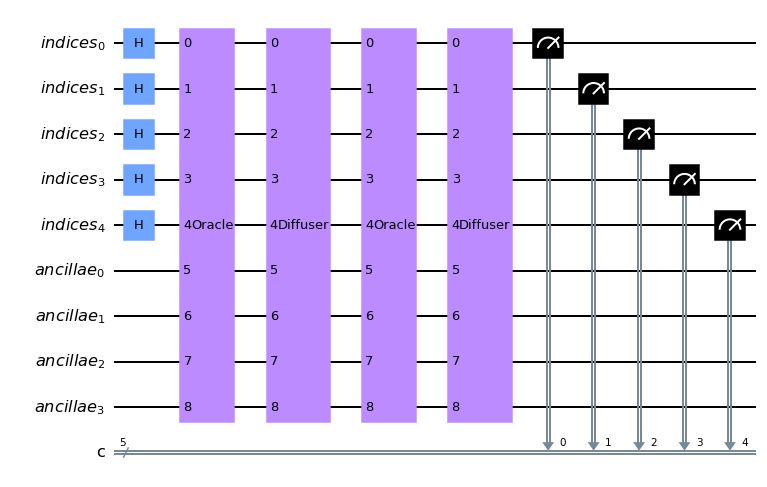

Job Status: job has successfully run
{'00000': 40, '00001': 23, '10000': 26, '10001': 23, '10010': 23, '10011': 27, '10100': 21, '10101': 27, '10110': 25, '10111': 24, '11000': 24, '11001': 22, '11010': 26, '11011': 154, '11100': 27, '11101': 19, '11110': 14, '11111': 31, '00010': 22, '00011': 25, '00100': 25, '00101': 26, '00110': 27, '00111': 31, '01000': 27, '01001': 25, '01010': 41, '01011': 24, '01100': 46, '01101': 34, '01110': 34, '01111': 37}
Time Taken for Job One: 0.007134199142456055

Total program running time: 0.007134199142456055


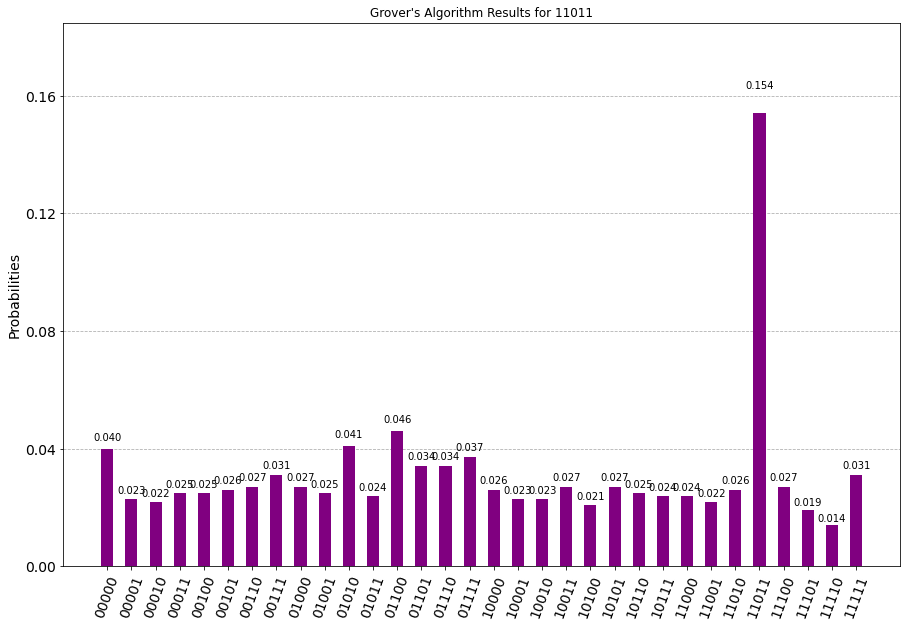

Circuit size: 82.000000
Circuit Depth: 26.000000




In [70]:
#############################################################################
# This function acts as the phase shift component of the Grover iteration.
# A general diffuser, it needs only the number of index and total qubits.
#############################################################################
def diffuser(qb, total):
    qc = QuantumCircuit(total)
    for qubit in range(qb):
        qc.h(qubit)
    
    for qubit in range(qb):
        qc.x(qubit)
        
    qc.h(qb-1)
    qc.mct([*range(qb)], total-1)  # multi-controlled Toffoli
    qc.h(qb-1)
    
    for qubit in range(qb):
        qc.x(qubit)
    
    for qubit in range(qb):
        qc.h(qubit)
        
    #display(qc.draw('mpl'))
    Diffuser = qc.to_gate()
    Diffuser.name = "Diffuser"
    return Diffuser
#############################################################################
# This function places the index register into superposition.
#############################################################################
def initialize(qc, qubits):
    for q in qubits:
        qc.h(q)
    return qc
#############################################################################
# This function creates an oracle for detecting '11011'. 
#############################################################################
def oracle_maker(qb):
    ###11011
    qc = QuantumCircuit(qb)
    qc.ccx(0,1,5)
    qc.x(7)
    qc.ccx(3,4,6)
    qc.cx(2,7)
    qc.mcx([5,6,7],8)
    qc.z(8)
    qc.mcx([5,6,7],8)
    qc.cx(2,7)
    qc.ccx(3,4,6)
    qc.ccx(0,1,5)
    qc.x(7)
    ###11011
    
    #display(qc.draw('mpl'))
    oracle = qc.to_gate()
    oracle.name = "Oracle"
    
    return oracle
#############################################################################
#############################################################################
n_qb = 5        # Number of index qubits
total = 4+n_qb  # Number of total qubits, index + ancillae
val = '11011'   # The value to be detected, for reference
sim = True      # Boolean for whether to run the circuit on simulator or hardware

if sim is True:
    backend = Aer.get_backend('qasm_simulator') 
    print("Running on qasm_simulator.\n")
else:
    backend = provider.backends.ibmq_16_melbourne
    print(f'Running on {backend}\n')

ind = QuantumRegister(n_qb, name='indices')           # Creation of index regiser
anc = QuantumRegister(4, name='ancillae')             # Creation of ancilla register
cla = ClassicalRegister(n_qb, name='c')               # Creation of classical register, for measurement
qc = QuantumCircuit(ind,anc,cla)                      # Creation of the overall circuit

initialize(qc, [*range(n_qb)])                        # Puts the index register into superposition


for i in range(int(np.sqrt(n_qb))):                   # Applies the Grover iteration sqrt(n) times 
    qc.append(oracle_maker(total), [*range(total)])   # Appends the oracle to the circuit
    qc.append(diffuser(n_qb, total), [*range(total)]) # Appends the diffuser/phase shift to the circuit

qc.measure(ind, cla)     # Measures the index circuit
display(qc.draw('mpl'))  # Graphically displats the overall circuit

job = execute(qc, backend=backend, 
                shots=1000, optimization_level=3)    # Creates a job object to run circuit on selected backend
                                                     # shots = number of times run, optim. = backend optimization
job_monitor(job, interval = 2)                       # Initializes the job monitor to determine when job runs
results = job.result()                               # Creates a results object from the run job                
answer = results.get_counts(qc)                      # Creates a 'counts' object which contains the results of the job                         
print(answer)                                        
print(f'Time Taken for Job One: {results.time_taken}\n')

runtime = results.time_taken                         # Find the overall time taken to run the job
print(f'Total program running time: {runtime}')
display(plot_histogram(answer, figsize=(15,10),      # Dispalys the job results as a histogram
    color='purple', title="Grover's Algorithm Results for 11011")) 

##########################################
# Additional circuit specifications
##########################################
trans_circOne = transpile(qc, backend)               # Returns the transpiled circuit.
trans_circOne.draw(filename='trans.png')             # Draws the transpiled circuit.
sizeOne = trans_circOne.size();                      # Returns the size of the transpiled circuit.
depthOne = trans_circOne.depth();                    # Returns the depth of the transpiled circuit
print("Circuit size: %f" % sizeOne)                  # Prints the transpiled circuit size.
print("Circuit Depth: %f\n\n" % depthOne)            # Prints the transpiled circuit depth.
##########################################

    
